In [1]:
import warnings
warnings.filterwarnings("ignore")

import scutils_cnb_clean
from scutils_cnb_clean import *
np.random.seed(1263)

from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d.art3d import LineCollection
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score

import gseapy
from gseapy.plot import gseaplot
from scipy.stats import entropy

from scipy.stats import t

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
%matplotlib inline

In [4]:
working_dir = '/Users/burdziac/Documents/PDAC/notebooks_final_June2021/'

# Hard-coded Metadata

In [5]:
#updated to include stage labels for this specific analysis (separating PDACs)
color_dict = {"T3":"#EED04D",
"T4":"#1D89E3",
"T5":"#F8BADE",
"PDAC_936":"#63009B",
"PDAC_020":"#BD14DA"}

In [6]:
#mapping of RNA and ATAC sample names to their corresponding conditions
#b/c different naming schemes of RNA and ATAC samples
stage_dict = {'DACC963_PT_B_mKate':"PDAC_936",
           'DACC963_mKate_plus':"PDAC_936",
           'DACD408_b_mKATE2_ATAC':"T3",
           'DACD404_b_mKATE2_ATAC':"T4",
           'DACE270_Epi':"T5",
           'DACE271_Epi':"T5",
           'DAC_D020_p5_Epi_ATAC':"PDAC_020"}

RNAmap = {'DACC963LIVERmet':"PDAC_936",
          "DACC963PT_Kate_plus":"PDAC_936",
          'DACD404_Kate_plus':"T4",
          'DACD406_Kate_plus':"T3",
          "DACD407_Kate_plus":"T4",
          'DACD351_Kate_plus':"T3",
          'DACD394_Kate_plus':"T3",
           'DACD482_Kate_plus': 'T5',
          'DAC_C269_EPI': 'T5',
          'DAC_DI143_Epi': 'T5',
          'DAC_D020_p5_Epi':"PDAC_020"}

stage_dict.update(RNAmap)

In [7]:
#order of scRNA-seq samples in terms of progression stage
order = [ 'DACD351_Kate_plus',
 'DACD394_Kate_plus',
 'DACD406_Kate_plus',
"DACD404_Kate_plus",
"DACD407_Kate_plus",
"DAC_DI143_Epi",
"DACD482_Kate_plus",
"DAC_D020_p5_Epi",
"DACC963PT_Kate_plus",
"DACC963LIVERmet",
"DACC963_mKate_plus"]

In [8]:
markers = ['IL33','DCLK1','VIM','IL6','TWIST1','TWIST2','SNAI1',
 'SNAI2','MUC6','MUC5','AGR2','TFF2','CLU','GCG','INS1','INS2',
 'PPY','SST','CPA1','REG3B','REG2','CTRB1',"PRSS2",'REG1','TRY5','REG3A',
 'ZG16','TRY4','TRY10','KRT18','ALB','SPP1','CD14','SOX9','KRT19']

# Functions for MNN, Graph Visualization

In [9]:
#From Harmony by Manu Setty
#function to construct mutually nearest neighbors bewteen two points
def _construct_mnn(t1_cells, t2_cells, data_df, n_neighbors):
    #t1_cells gives indices of cells in set1
    #t2_cells gives indices of cells in set2
    #data_df contains combined data of set1 and set2
    
    print(f't+1 neighbors of t...')
    nbrs = NearestNeighbors(n_neighbors=n_neighbors,
                            metric='cosine', n_jobs=1)
    nbrs.fit(data_df.loc[t1_cells, :].values)
    t1_nbrs = nbrs.kneighbors_graph(
        data_df.loc[t2_cells, :].values, mode='distance') #get t1 neighbors of t2 cells

    print(f't neighbors of t+1...')
    nbrs = NearestNeighbors(n_neighbors=n_neighbors,
                            metric='cosine', n_jobs=1)
    nbrs.fit(data_df.loc[t2_cells, :].values)
    t2_nbrs = nbrs.kneighbors_graph(
        data_df.loc[t1_cells, :].values, mode='distance') #get t1 neighbors of t2 cells

    #mututally nearest neighbors
    mnn = t2_nbrs.multiply(t1_nbrs.T) #zeros out any which are not mutual
    mnn = mnn.sqrt() #square root of those which were mutual which did get multipled
    
    mnn_full = np.pad(mnn.toarray(),((0,np.sum(data_df.index!=t1_cells)),
               (np.sum(data_df.index==t1_cells),0)),
               mode='constant',constant_values=0)
    
    return mnn_full

#function to construct inidivual nearest neighbor graphs bewteen two points
def _construct_nn_sep(t1_cells, t2_cells, data_df, n_neighbors):
    print(f't neighbors of t...')
    nbrs = NearestNeighbors(n_neighbors=n_neighbors,
                            metric='cosine', n_jobs=1)
    nbrs.fit(data_df.loc[t1_cells, :].values)
    t1_nbrs = nbrs.kneighbors_graph(
        data_df.loc[t1_cells, :].values, mode='distance') #get t1 neighbors of t1 cells

    print(f't+1 neighbors of t+1...')
    nbrs = NearestNeighbors(n_neighbors=n_neighbors,
                            metric='cosine', n_jobs=1)
    nbrs.fit(data_df.loc[t2_cells, :].values)
    t2_nbrs = nbrs.kneighbors_graph(
        data_df.loc[t2_cells, :].values, mode='distance') #get t2 neighbors of t2 cells

    #combine neighbors in one N by N matrix
    t1_nbrs = np.pad(t1_nbrs.toarray(),((0,np.sum(data_df.index!=t1_cells)),
               (0,np.sum(data_df.index!=t1_cells))), mode='constant',constant_values=0)
    t2_nbrs = np.pad(t2_nbrs.toarray(),((np.sum(data_df.index==t1_cells),0),
               (np.sum(data_df.index==t1_cells),0)), mode='constant',constant_values=0)
    
    return t1_nbrs+t2_nbrs

In [10]:
#function to plot graph edges between points on a 2D embedding
def plot_G_weighted_edges(tsne, G, alpha_G=0.7, s=10, t='k' ,figsize=(15,15),
                    cmap='viridis', ax=None,scale=10.0):
    
    #set up the figure
    fig,ax = plt.subplots(figsize=figsize)
    
    #collect the points for each segment
    segments = [tsne[[i, j],:] for (i, j) in G.todok().keys() if i < j]
    
    #collect line widths 
    colors = [G[i, j] for (i, j) in G.todok().keys() if i < j]

    #plot line segments
    ax.add_collection(LineCollection(segments,colors='k',
                                     alpha=alpha_G,
                                     linewidths=np.array(colors)*scale))

    #plot points, colored by t value
    ax.scatter(tsne[:,0],tsne[:,1], marker='o',s=s,c=t,cmap=cmap,zorder=2)
    ax.set_axis_off()
    return ax

# Manually Assign Cluster Labels

In [11]:
sc = load_sc(working_dir+"saved_analyses/ATACIntegrationSet_EC2.pickle")

In [12]:
#maps ATAC clusters to labels
cluster_labels_ATAC={0: "Muc", ##from 0,4
                     1: "Prog", ##from 1
                     2: "Prog", ##from 8
                     3: "Acinar", ##from 3
                     4: "Acinar", ##from 12
                     5: "NE", ##from 6,7
                     6: "Tuft", ##from 9,10
                     7: "PDAC1", ##from 5,11
                     8: "PDAC2"} ##from 2

In [13]:
#maps refined RNA clusters to labels
cluster_labels = {0:"Muc",
                  2:"Muc",
                  3:"Prog",
                  4:"PDAC1",
                  6:"Acinar",
                  7:"PDAC2",
                  8:"PDAC2",
                  9:"Prog",
                  11:"NE",
                  13:"PDAC2",
                  15:"Shared PDAC",
                  17:"Tuft",
                  18:"Acinar",
                  19:"Acinar to PDAC",
                  20:"PDAC2"}

In [14]:
#colors for labels
color_labels = {"Muc":sc.palette[0],
                "Prog":sc.palette[1],
                "Tuft":sc.palette[13],
                "NE":sc.palette[9],
                "PDAC1":sc.palette[5],
                "PDAC2":sc.palette[6],
                'Acinar':sc.palette[3],
                'Shared PDAC':sc.palette[11],
                "Acinar to PDAC":sc.palette[14]}

In [15]:
clusters_refined = np.array(list(set(sc.communities_refined)))

#define which scRNA clusters to filter based on cluster size
clust_sizes = np.array([np.sum(sc.communities_refined==clust) for clust in clusters_refined])
large_clusts = clusters_refined[np.where(np.array(clust_sizes>=200))[0]]

# Read in Metacells and Pre-process

In [16]:
#new merged ATAC clusters from Julia's code
new_clusters  = pd.read_csv(working_dir+"final_outputs/Figure3/scATAC_Round2_v2_Jan2722/merged_clusters.csv"
                            ,index_col=0)

In [17]:
#read in pre-computed RNA and ATAC metacells
metacell_data = pd.read_csv(working_dir+"final_outputs/Figure3/ATACIntegrationSet_metacells_log_genescores.csv",index_col=0)
metacell_atac = pd.read_csv(working_dir+"analysis_outputs/scATAC_Round2_v2_Jan2722/Round2_metacells_genescores.csv",index_col=0)

#grab the metacells from RNA which are in the clusters passing the filter above
good_cells_rna = np.where(np.array([cell in large_clusts for cell in metacell_data['Cluster_Refined'].values]))[0]
metacell_data = metacell_data.iloc[good_cells_rna]

atac_clusters = new_clusters.loc[metacell_atac.index].values.flatten() #get ATAC metacell clusters from new_clusters
atac_samples = metacell_atac['SampleID'].values #get sample ID
atac_clusters_colors = np.array([color_labels[cluster_labels_ATAC[i]] for i in atac_clusters])
atac_samples_colors = np.array([color_dict[stage_dict[i]] for i in atac_samples])

rna_clusters = metacell_data['Cluster_Refined'].values
rna_samples = metacell_data['SampleID'].values
rna_clusters_colors = np.array([color_labels[cluster_labels[i]] for i in rna_clusters])
rna_samples_colors = np.array([color_dict[stage_dict[i]] for i in rna_samples])

metacell_data = metacell_data.drop(['Cluster','Cluster_Refined','SampleID','CellID'],axis=1)
metacell_atac = metacell_atac.drop(['Cluster','SampleID','CellID'],axis=1)

metacell_atac.index = ['ATACseq']*metacell_atac.shape[0]
metacell_data.index = ['RNAseq']*metacell_data.shape[0]

In [18]:
#remove zero-sum genes
metacell_data = metacell_data.iloc[:,np.where(metacell_data.values.sum(0)!=0)[0]]
metacell_atac = metacell_atac.iloc[:,np.where(metacell_atac.values.sum(0)!=0)[0]]

In [19]:
#uppease names in metacell_atac data
metacell_atac.columns = [gene.upper() for gene in list(metacell_atac)]

In [20]:
#get shared genes
shared_genes = np.intersect1d(list(metacell_data),list(metacell_atac))
metacell_data = metacell_data[shared_genes]
metacell_atac = metacell_atac[shared_genes]

# Basic Integration

## Z-score and Combine Data

In [21]:
#z_score both datasets
z_data_atac = (metacell_atac-metacell_atac.mean(0))/metacell_atac.std(0)
z_data_data = (metacell_data-metacell_data.mean(0))/metacell_data.std(0)

#concatenate the datasets
z_data = pd.concat((z_data_atac,z_data_data))

In [22]:
combined_samples = np.concatenate((atac_samples,rna_samples))
combined_clusters = np.concatenate((atac_clusters,rna_clusters))

combined_samples_colors = np.array([color_dict[stage_dict[sample]] for sample in combined_samples])
combined_clusters_colors = np.concatenate((atac_clusters_colors,rna_clusters_colors))

In [23]:
atac_ix = np.where(np.array(z_data.index=='ATACseq'))[0]
rna_ix = np.where(np.array(z_data.index=='RNAseq'))[0]

In [24]:
technology_coloring = np.array(['#61C8F1']*z_data.shape[0])
technology_coloring[atac_ix] = "#F161A9"

## Dimensionality Reduction and Visualization

In [25]:
pc = PCA(n_components=50)
pc = pc.fit_transform(z_data)
embedding = bhtsne.tsne(pc,perplexity=30)

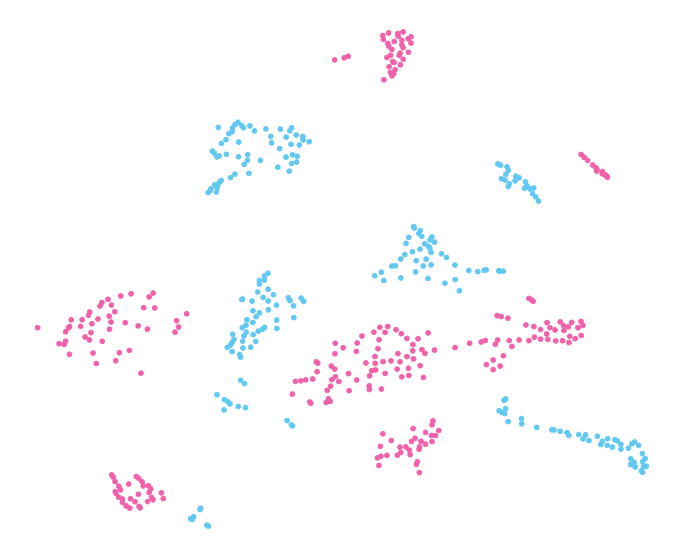

In [26]:
fig,ax = plt.subplots(figsize=(12,10))

ax.scatter(embedding[:,0], embedding[:,1],c=technology_coloring)
ax.set_axis_off()

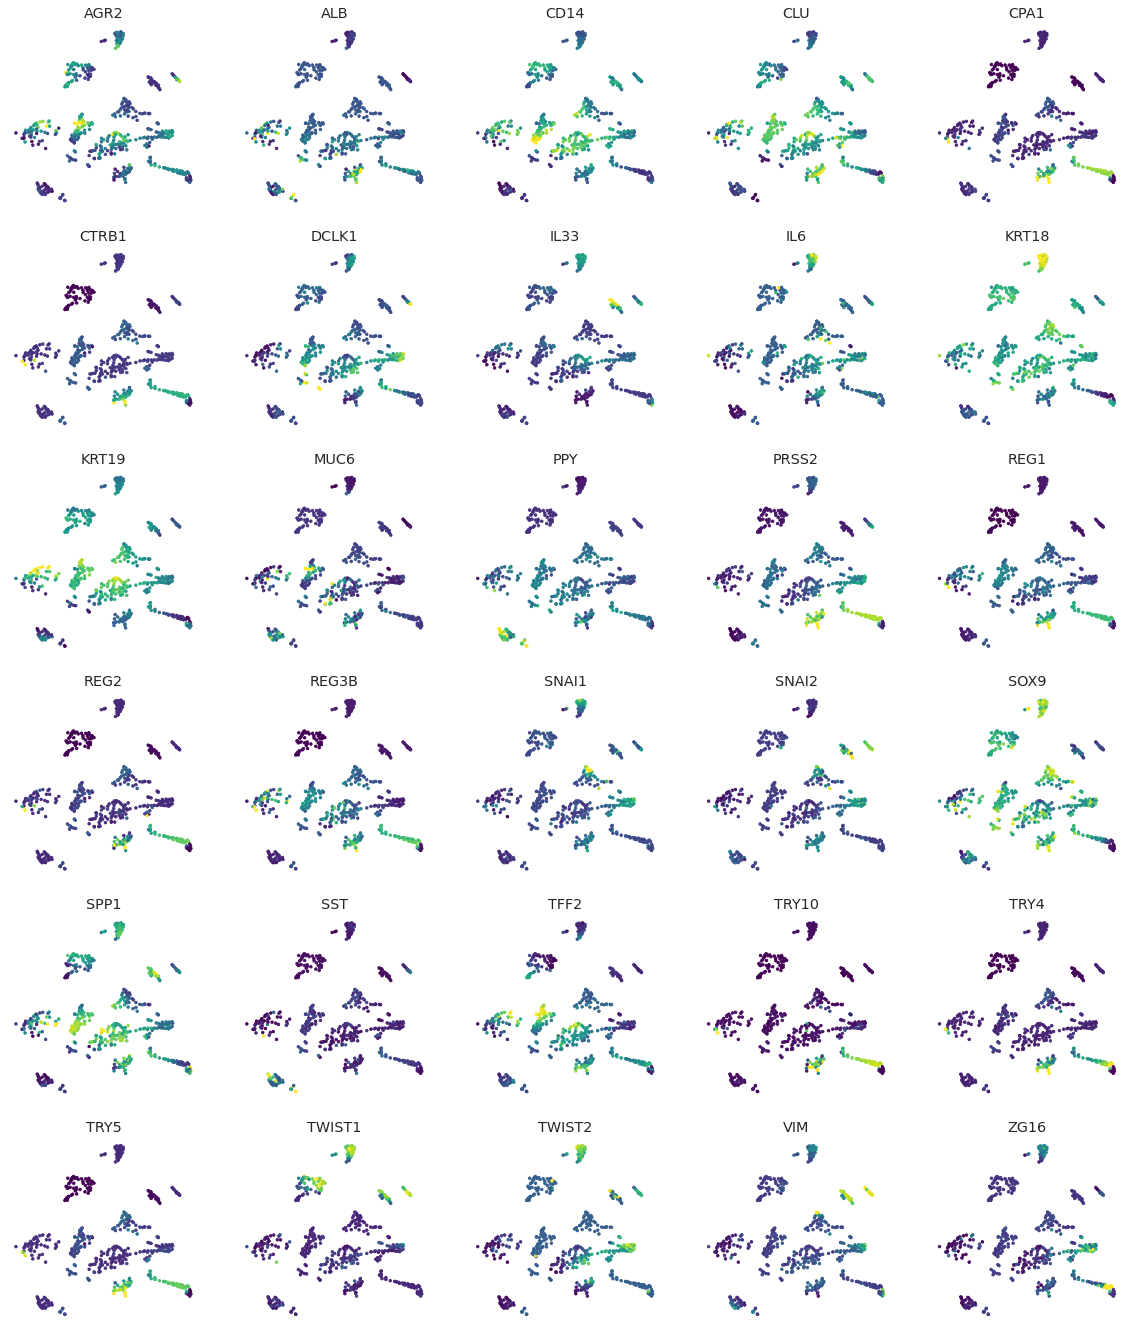

In [27]:
gene_plot(embedding,np.exp(z_data),markers,cmap='viridis')

## Mutually Nearest Neighbors Analysis

In [28]:
pc_df = pd.DataFrame(pc,index=z_data.index)

In [29]:
MNN_full = _construct_mnn('ATACseq','RNAseq',pc_df,n_neighbors=30)
MNN_full = MNN_full + MNN_full.T

t+1 neighbors of t...
t neighbors of t+1...


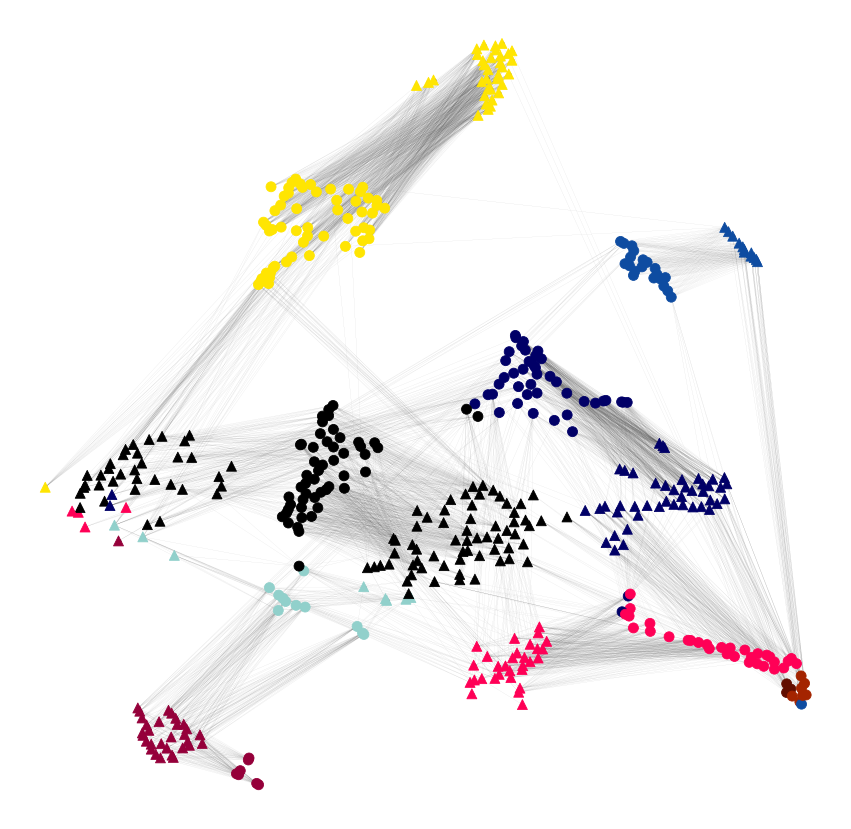

In [30]:
ax = plot_G_weighted_edges(embedding,
                           csr_matrix(MNN_full),
                           scale=.05)

ax.scatter(embedding[:,0][atac_ix], 
            embedding[:,1][atac_ix],s=100,
            c=np.array(combined_clusters_colors)[atac_ix],marker="^",zorder=2)

ax.scatter(embedding[:,0][rna_ix], 
            embedding[:,1][rna_ix],s=100,
            c=np.array(combined_clusters_colors)[rna_ix],zorder=2)
ax.set_axis_off()

In [31]:
NN_full = _construct_nn_sep('ATACseq','RNAseq',pc_df,n_neighbors=30)
NN_full = NN_full + NN_full.T

t neighbors of t...
t+1 neighbors of t+1...


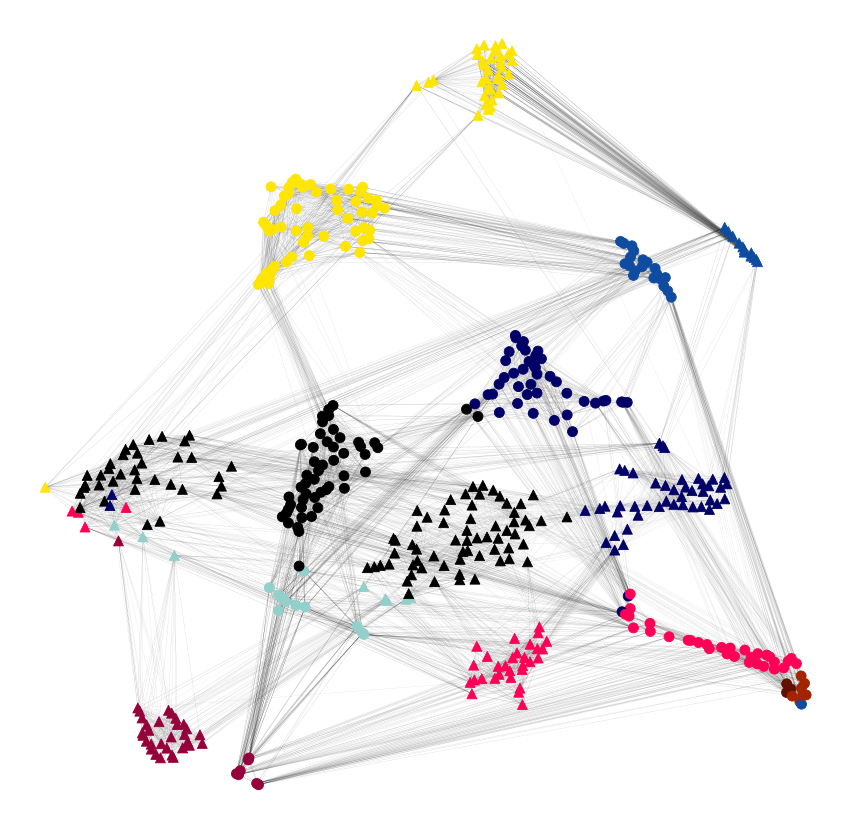

In [32]:
ax = plot_G_weighted_edges(embedding,
                           csr_matrix(NN_full),
                           scale=.1)


ax.scatter(embedding[:,0][atac_ix], 
            embedding[:,1][atac_ix],s=100,
            c=np.array(combined_clusters_colors)[atac_ix],marker="^",zorder=2)

ax.scatter(embedding[:,0][rna_ix], 
            embedding[:,1][rna_ix],s=100,
            c=np.array(combined_clusters_colors)[rna_ix],zorder=2)
ax.set_axis_off()

In [33]:
alpha = .4
combined_graph = (MNN_full*alpha)+(NN_full*(1.0-alpha))

In [34]:
layout = harmony.plot.force_directed_layout(combined_graph,iterations=1000)

100%|██████████| 1000/1000 [00:02<00:00, 405.12it/s]

BarnesHut Approximation  took  0.80  seconds
Repulsion forces  took  1.19  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.17  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


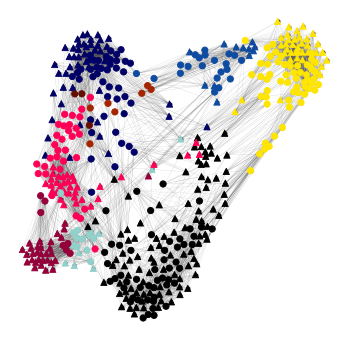

In [35]:
ax = plot_G_weighted_edges(layout.values,
                           csr_matrix(MNN_full),
                           scale=.1,figsize=(6,6))

ax.scatter(layout.values[:,0][atac_ix], 
            layout.values[:,1][atac_ix],s=40,
            c=np.array(combined_clusters_colors)[atac_ix],marker="^",zorder=2)

ax.scatter(layout.values[:,0][rna_ix], 
            layout.values[:,1][rna_ix],s=40,
            c=np.array(combined_clusters_colors)[rna_ix],zorder=2)
ax.set_axis_off()

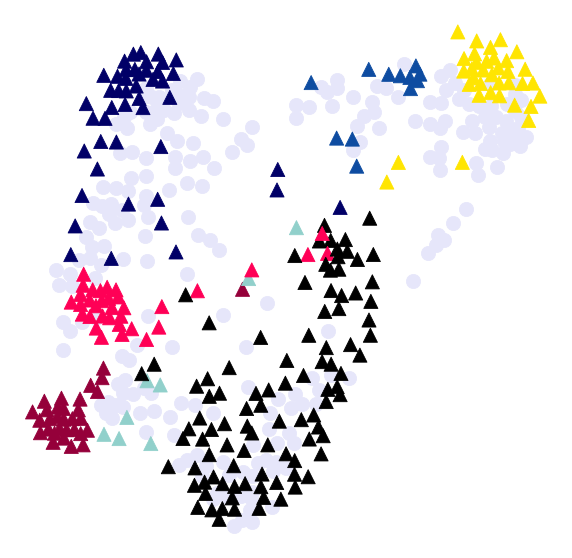

In [36]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.scatter(layout.values[:,0][atac_ix], 
            layout.values[:,1][atac_ix],s=200,
            c=np.array(combined_clusters_colors)[atac_ix],marker="^",zorder=2)

ax.scatter(layout.values[:,0][rna_ix], 
            layout.values[:,1][rna_ix],s=200,
            c='lavender',zorder=0)

ax.set_axis_off()

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_CombinedFDL_ATAC.png"
                ,bbox_inches='tight')

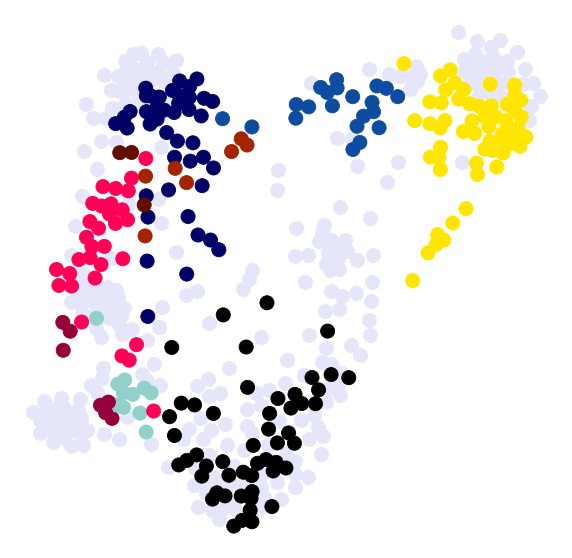

In [37]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.scatter(layout.values[:,0][atac_ix], 
            layout.values[:,1][atac_ix],s=200,
            c='lavender',zorder=0)

ax.scatter(layout.values[:,0][rna_ix], 
            layout.values[:,1][rna_ix],s=200,
            c=np.array(combined_clusters_colors)[rna_ix],zorder=2)
ax.set_axis_off()

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_CombinedFDL_RNA.png"
                ,bbox_inches='tight')

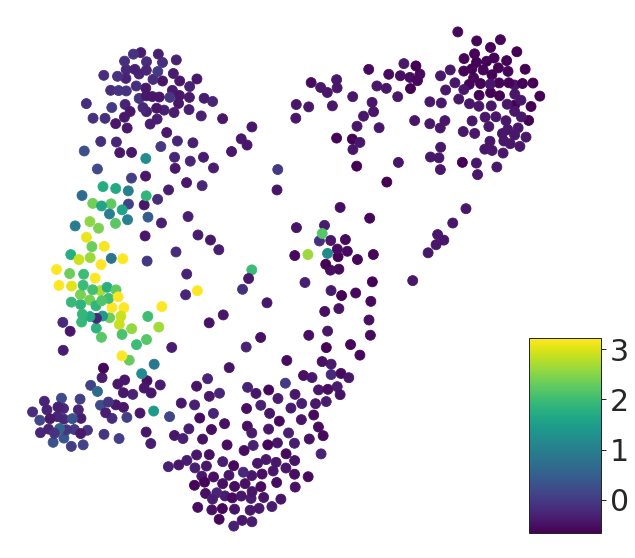

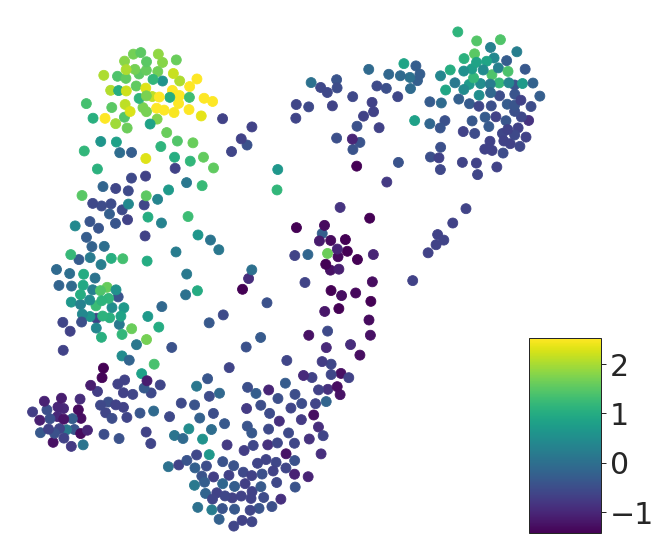

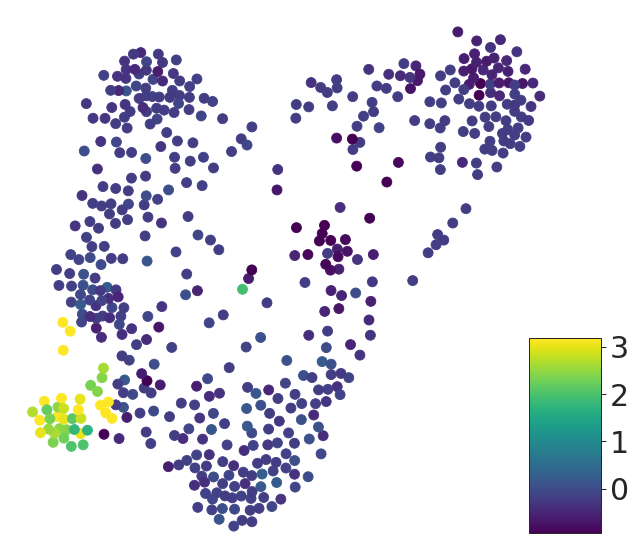

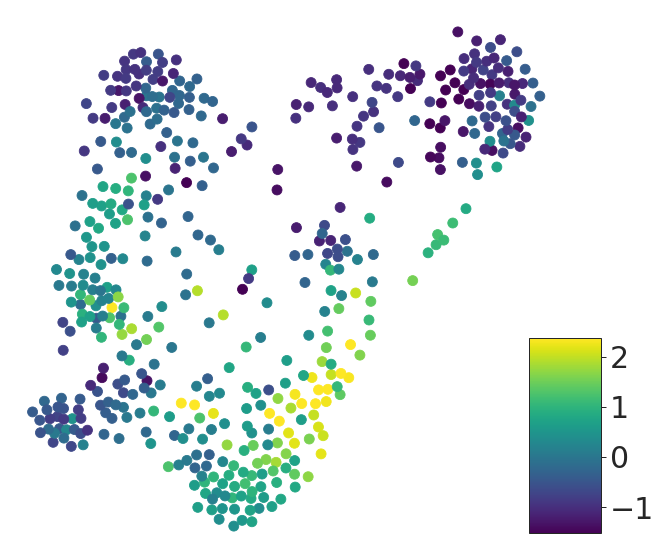

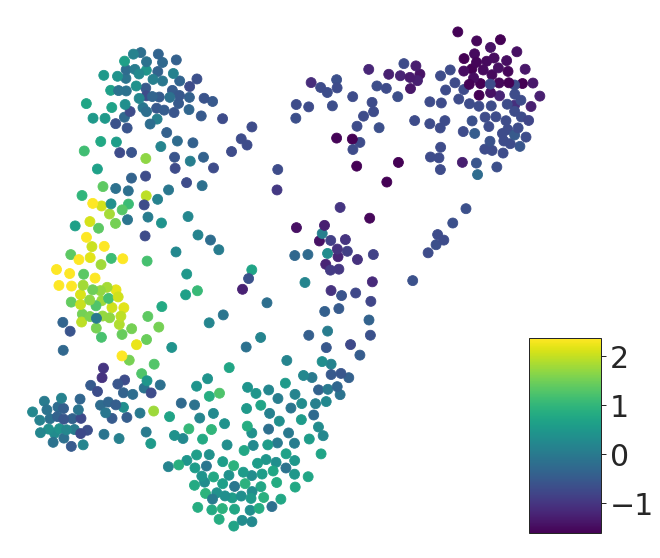

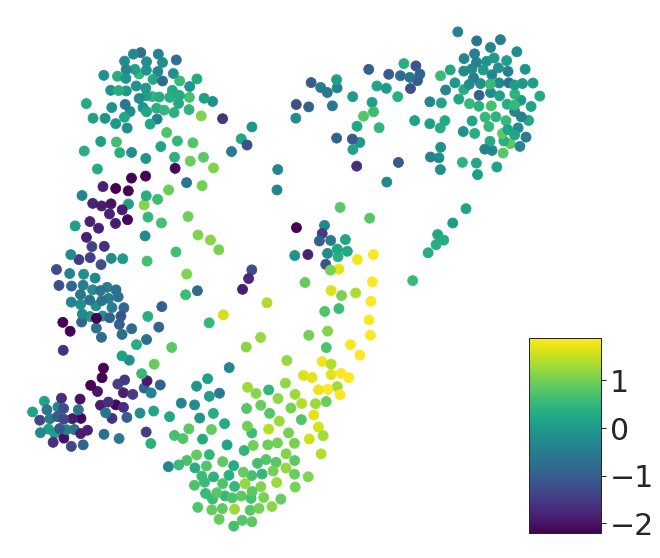

In [38]:
for gene in ['PTF1A','NES','NEUROD1','TFF2','NR5A2','KRT19']:
    colors = z_data[gene]
    order_ = np.random.choice(z_data.shape[0],size=z_data.shape[0],replace=False)
    
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    scatterplt = ax.scatter(layout.values[:,0][order_],layout.values[:,1][order_],c=colors[order_],s=100,
              cmap='viridis',vmin=np.percentile(colors,2),vmax=np.percentile(colors,98))
    ax.set_axis_off()
    
    cax = fig.add_axes([.85, .15, 0.1, 0.27])
    cbar = fig.colorbar(scatterplt, cax)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(30)

    plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_CombinedFDL_{}.png".format(gene)
                ,bbox_inches='tight')

In [39]:
layout.to_csv(working_dir+"final_outputs/Figure3/CombinedFDL_Metacell.csv")

### Metacell Correlation Plots

In [40]:
#for each RNA metacell, generate one aggregate ATAC profile from mutually nearest neighbors
agg_atac = np.zeros((len(rna_ix),z_data.shape[1]))
for RNAcell in range(len(rna_ix)):
    mnn_ix = rna_ix[RNAcell]
    #average the metacell ATAC profiles associated with each RNA metacell from MNN
    agg_atac[RNAcell,:] = metacell_atac.iloc[np.where(MNN_full[:,mnn_ix])[0]].mean(0).values

agg_atac = pd.DataFrame(agg_atac,columns=list(metacell_atac)) #put in a dataframe
good_ix = np.where(agg_atac.sum(1)!=0)[0] #zero metacells cells
agg_atac = agg_atac.iloc[good_ix,:] #drop zero metacells
z_agg_atac = (agg_atac-agg_atac.mean(0))/agg_atac.std(0) #standardize
z_agg_data = z_data.loc['RNAseq'].iloc[good_ix]

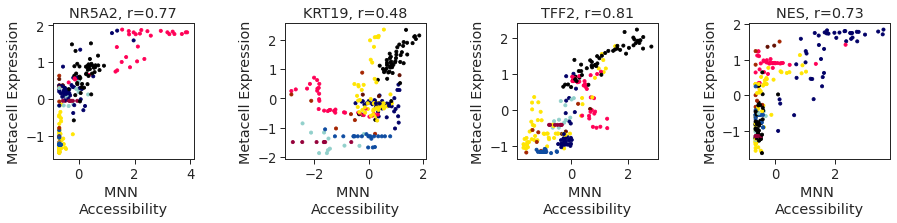

In [41]:
fig,axes = plt.subplots(1,4,figsize=(15,2.5))

for i,gene in enumerate(['NR5A2','KRT19','TFF2','NES']):
    y = z_agg_atac[gene].values
    x = z_agg_data[gene].values
    ax = axes.flatten()[i]
    ax.scatter(x,y,c=np.array(combined_clusters_colors)[rna_ix[good_ix]],s=10)
    ax.set_title("{}, r={}".format(gene,np.round(np.corrcoef(x,y)[0,1],2)))
    ax.set_ylabel("Metacell Expression")
    ax.set_xlabel("MNN \nAccessibility")

plt.subplots_adjust(wspace=.65, hspace=0)

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_ScatterPlotPerGene.pdf",bbox_inches='tight')

0.2665140910868836
0.2692297922172991


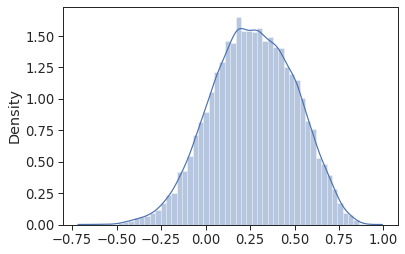

In [42]:
all_gene_corrs = []
for gene in list(z_agg_atac):
    y = z_agg_atac[gene].values
    x = z_agg_data[gene].values
    all_gene_corrs.append(np.corrcoef(x,y)[0,1])
sns.distplot(all_gene_corrs)
print(np.mean(all_gene_corrs))
print(np.median(all_gene_corrs))

## Correlation Analysis

In [43]:
#compute pairwise correlation between standardized ATAC and RNA metacells
#correlation only on HVGs!
corrs_ = np.corrcoef(z_data[np.intersect1d(list(sc.data_normalized),list(z_data))])
#corrs_ = np.corrcoef(z_data)

#subset to ATAC on rows and RNA on columns
corrs = corrs_[atac_ix,:][:,rna_ix]

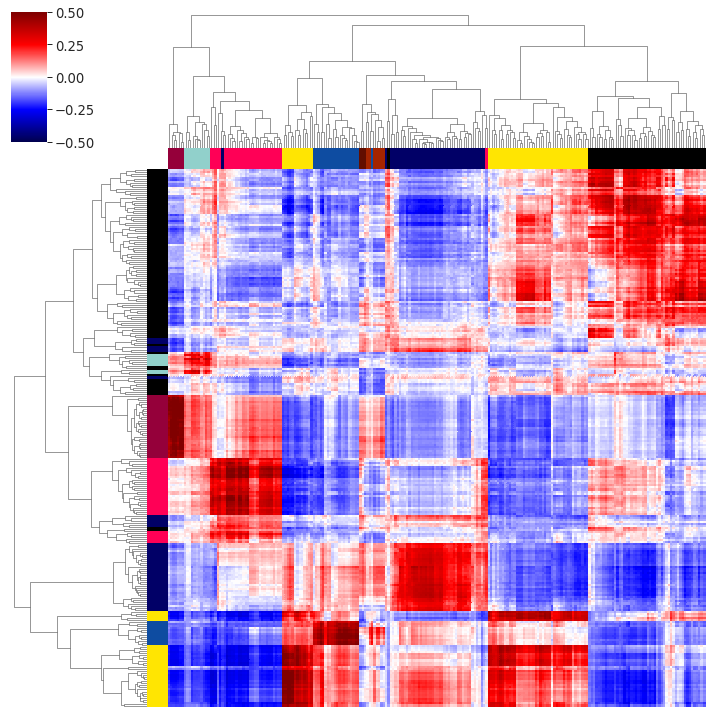

In [44]:
#visualize as heatmap
corr_map = sns.clustermap(corrs,
               row_colors=atac_clusters_colors,
               col_colors=rna_clusters_colors,
               xticklabels="",yticklabels="",cmap='seismic',figsize=(10,10),vmax=.5,vmin=-.5)

In [45]:
#for custom ordering, get cell type label of each cluster
atac_clusters_mapped = np.array([cluster_labels_ATAC[i] for i in atac_clusters])
rna_clusters_mapped = np.array([cluster_labels[i] for i in rna_clusters])

In [46]:
#pre-define a cluster ordering
cluster_order = ['Acinar',"NE",'Tuft',"Muc","Prog", 'Acinar to PDAC',"Shared PDAC",'PDAC1',"PDAC2"]

atac_ix_corr,rna_ix_corr = [],[]
atac_clusters_colors_corr,rna_clusters_colors_corr = [],[]

for cluster in cluster_order:
    rna_ix_corr.append(np.where(rna_clusters_mapped==cluster)[0]) #append indices of that cluster in RNA
    atac_ix_corr.append(np.where(atac_clusters_mapped==cluster)[0]) #append indices of that cluster in ATAC
    rna_clusters_colors_corr+= [color_labels[cluster]]*len(rna_ix_corr[-1]) #add colors
    atac_clusters_colors_corr+= [color_labels[cluster]]*len(atac_ix_corr[-1]) #add colors

rna_ix_corr=np.concatenate(rna_ix_corr) #concatenate
atac_ix_corr=np.concatenate(atac_ix_corr) #concatenate

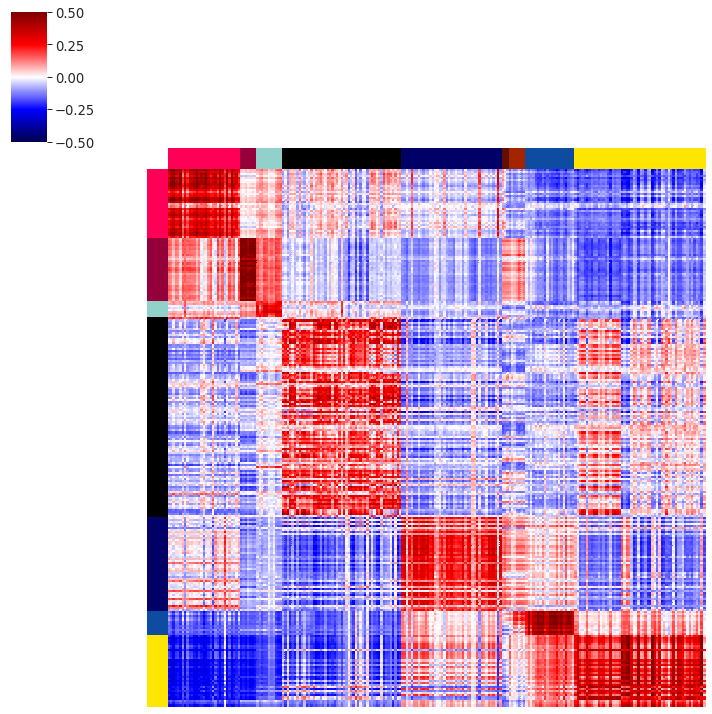

In [47]:
corr_map = sns.clustermap(corrs[atac_ix_corr,:][:,rna_ix_corr],
               row_colors=atac_clusters_colors_corr,
               col_colors=rna_clusters_colors_corr,
               row_cluster=False,col_cluster=False,
               xticklabels="",yticklabels="",cmap='seismic',
               figsize=(10,10),vmax=.5,vmin=-.5)

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_CorrelationHeatmap.pdf"
                ,bbox_inches='tight')
plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_CorrelationHeatmap.svg"
                ,bbox_inches='tight')

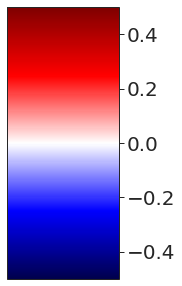

In [48]:
fig,ax = plt.subplots(figsize=(2,5))

#adding colorbar
cmap = plt.get_cmap('seismic')
norm = mpl.colors.Normalize(vmin=-.5, vmax=.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(20)
plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_CorrelationHeatmap_cbar.pdf",bbox_inches='tight')

# Plasticity Analyses

In [49]:
#first, validate accuracy of training
training_ix = np.random.choice(range(len(rna_ix)),size=int(np.ceil(len(rna_ix)*.6)),replace=False)
testing_ix = np.array(list(set(range(len(rna_ix)))-set(training_ix)))
print(len(training_ix),len(testing_ix))

model_validation = LogisticRegression(multi_class='ovr')
model_validation.fit(z_data_data.values[training_ix,:],rna_clusters[training_ix])
preds = model_validation.predict(z_data_data.iloc[testing_ix])

print(accuracy_score(rna_clusters[testing_ix],preds))
print(precision_score(rna_clusters[testing_ix],preds,average='macro'))
print(recall_score(rna_clusters[testing_ix],preds,average='macro'))

138 92
0.9456521739130435
0.9488888888888888
0.9444444444444444


In [50]:
model = LogisticRegression(multi_class='ovr')
#model = LogisticRegression() #works well with either
model.fit(z_data_data,rna_clusters)

atac_predict = model.predict(z_data_atac)
atac_predict_colors = np.array([color_labels[cluster_labels[i]] for i in atac_predict])

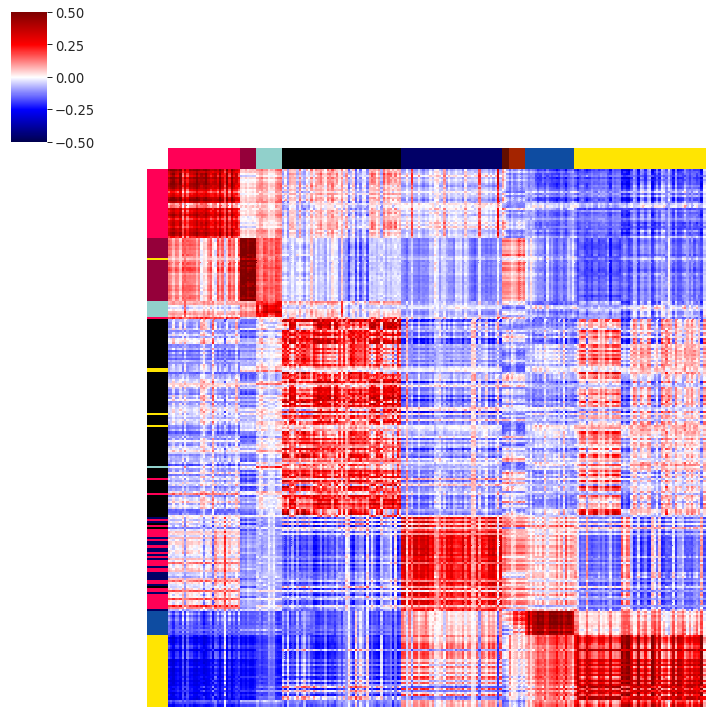

In [51]:
sns.clustermap(corrs[atac_ix_corr,:][:,rna_ix_corr],
               col_colors=rna_clusters_colors[rna_ix_corr],
               row_colors=atac_predict_colors[atac_ix_corr],
               col_cluster=False,row_cluster=False,
               xticklabels="",yticklabels="",cmap='seismic',figsize=(10,10),vmax=.5,vmin=-.5)

## Entropy of Predictions

In [52]:
atac_clusters_all = np.array(list(set(atac_clusters)))
print(atac_clusters_all)

rna_clusters_all = np.array(list(set(rna_clusters)))
print(rna_clusters_all)

[0 1 2 3 4 5 6 7 8]
[ 0  2  3  4  6  7  8  9 11 13 15 17 18 19 20]


In [53]:
atac_entropy = entropy(model.predict_proba(z_data_atac).T)

In [54]:
confusion_mat = np.zeros((len(set(atac_clusters)),len(set(rna_clusters))))
for ATAC_cluster in atac_clusters_all:
    predictions = model.predict(z_data_atac.iloc[np.where(atac_clusters==ATAC_cluster)[0]])
    predictions = [list(predictions).count(i) for i in rna_clusters_all]
    confusion_mat[ATAC_cluster,:] = predictions

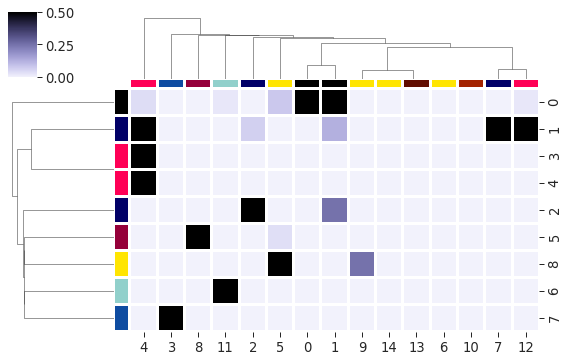

In [55]:
row_clusters = np.array([color_labels[cluster_labels_ATAC[i]] for i in atac_clusters_all])
col_clusters = np.array([color_labels[cluster_labels[i]] for i in rna_clusters_all])

confmat = sns.clustermap(confusion_mat,
               standard_scale=0,
               col_colors = col_clusters, 
               row_colors = row_clusters,
               cmap=sns.cubehelix_palette(start=3, rot=0, dark=0, light=.95,
               reverse=False, as_cmap=True),figsize=(8,5),
               linewidths=2, linecolor='white',vmax=.5)

Text(0.5, 0, '')

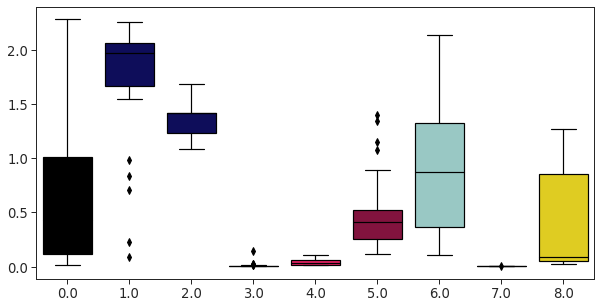

In [56]:
fig,ax=plt.subplots(figsize=(10,5))
tmp = pd.DataFrame((atac_entropy,atac_clusters),index=['entropy','cluster']).T
colors_boxplot = [color_labels[cluster_labels_ATAC[i]] for i in set(atac_clusters)]
sns.boxplot(data=tmp,x='cluster',y='entropy',palette=np.array(colors_boxplot))
#ax.set_xticks([])
ax.set_ylabel("")
ax.set_xlabel("")

In [57]:
#manual ordering
row_order_confmat = np.array([3,4,7,5,8,0,6,2,1])
col_order_confmat = np.array([4,12,3,8,5,9,6,0,1,11,2,7,10])

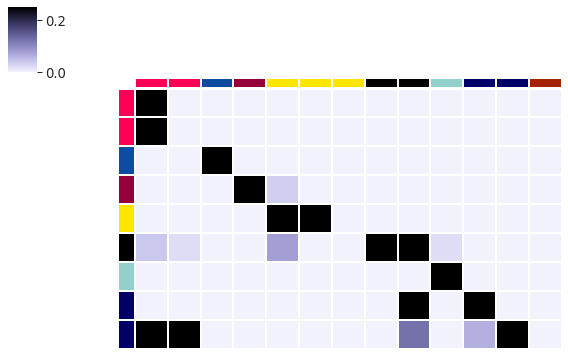

In [58]:
confmat = sns.clustermap(confusion_mat[row_order_confmat,:][:,col_order_confmat],
               standard_scale=0,
               col_cluster=False,row_cluster=False,
               col_colors = col_clusters[col_order_confmat], 
               row_colors = row_clusters[row_order_confmat],
               xticklabels = "",yticklabels="",
               cmap=sns.cubehelix_palette(start=3, rot=0, dark=0, light=.95,reverse=False, as_cmap=True),
               figsize=(8,5),
               linewidths=1.0, linecolor='white',vmax=.25)

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_HeatmapConfMat.pdf"
                ,bbox_inches='tight')

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_HeatmapConfMat.svg"
                ,bbox_inches='tight')

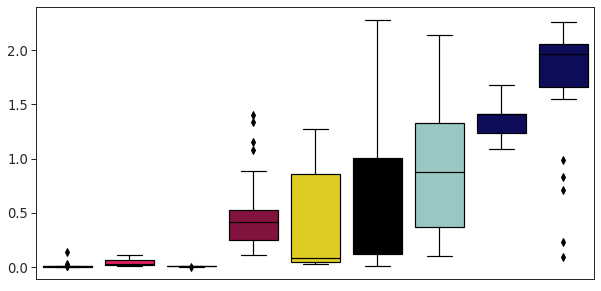

In [59]:
fig,ax=plt.subplots(figsize=(10,5))
tmp = pd.DataFrame((atac_entropy,atac_clusters),index=['entropy','cluster']).T
tmp.entropy = tmp.entropy.values.astype(np.float32)
colors_boxplot = [color_labels[cluster_labels_ATAC[i]] for i in set(atac_clusters)]
sns.boxplot(data=tmp,x='cluster',y='entropy',palette=np.array(colors_boxplot)[row_order_confmat],
            order=row_order_confmat)
ax.set_xticks([])
ax.set_ylabel("")
ax.set_xlabel("")

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_BoxplotPlasticity.pdf"
                ,bbox_inches='tight')

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_BoxplotPlasticity.svg"
                ,bbox_inches='tight')

In [60]:
prop_mat = np.zeros((len(set(atac_clusters)),len(set(rna_clusters))))
for ATAC_cluster in set(atac_clusters):
    predictions = model.predict_log_proba(z_data_atac.iloc[np.where(atac_clusters==ATAC_cluster)[0]].fillna(0)).mean(0)
    prop_mat[ATAC_cluster,:] = predictions

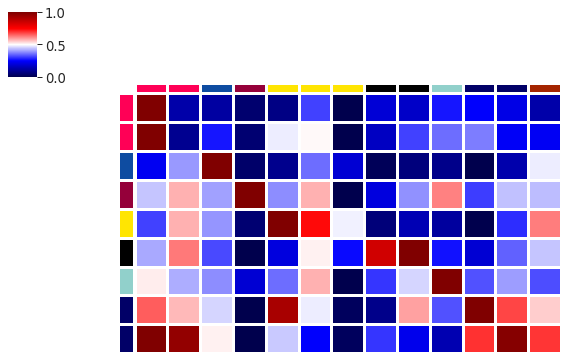

In [61]:
propmat = sns.clustermap(prop_mat[row_order_confmat,:][:,col_order_confmat],
               standard_scale=0,
               col_colors = col_clusters[col_order_confmat], 
               row_colors = row_clusters[row_order_confmat],
                col_cluster=False,row_cluster=False,
               cmap="seismic",figsize=(8,5),
               xticklabels = "",yticklabels="",
               linewidths=2, linecolor='white')

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_HeatmapProbMat.pdf"
                ,bbox_inches='tight')

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_HeatmapProbMat.svg"
                ,bbox_inches='tight')

### Plasticity by Stage

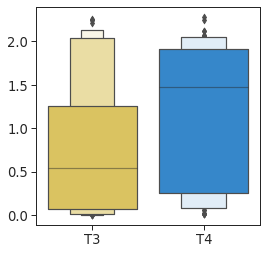

In [62]:
fig,ax=plt.subplots(figsize=(4,4))
atac_stages = np.array([stage_dict[i] for i in atac_samples])
stage_order= ['T3','T4']
tmp = pd.DataFrame((atac_entropy,atac_stages),index=['entropy','cluster']).T
colors_boxplot = [color_dict[i] for i in stage_order]
tmp.entropy = tmp.entropy.values.astype(np.float32)
sns.boxenplot(data=tmp,x='cluster',y='entropy',palette=np.array(colors_boxplot),order=stage_order)
#ax.set_xticks([])
ax.set_ylabel("")
ax.set_xlabel("")
plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_BoxplotT3T4.svg"
                ,bbox_inches='tight')

In [64]:
T4score = tmp.set_index("cluster").loc['T4']['entropy'].values
T3score = tmp.set_index("cluster").loc['T3']['entropy'].values

#outdated version of scipy can't do one-sided alternative
tstat,pval = scipy.stats.ttest_ind(a=T3score,b=T4score)
tstat

-2.5511448099330494

In [65]:
pval/2.0

0.006030881671372168

In [66]:
from scipy.stats import t
t.cdf(x=tstat,df=T4score.shape[0]+T3score.shape[0]-2)

0.006030881671372168

### Plasticity Score -Associated Genes

In [67]:
#find genes correlated with entropy score
entropy_corrs,entropy_corrs_p = np.zeros(len(list(z_data_atac))),np.zeros(len(list(z_data_atac)))
for i,gene in enumerate(list(z_data_atac)):
    r,p=scipy.stats.spearmanr(z_data_atac[gene],atac_entropy)
    entropy_corrs[i] = r
    entropy_corrs_p[i] = p

In [68]:
entropy_corrs = pd.DataFrame((list(z_data_atac),entropy_corrs),index=['gene','correlation']).T

In [69]:
entropy_corrs['correlation'] = entropy_corrs['correlation'].values.astype(np.float64)

In [70]:
pre_res = gseapy.prerank(rnk=entropy_corrs.dropna(), gene_sets='KEGG_2019_Mouse',
                     processes=6,
                     permutation_num=200, # reduce number to speed up testing
                     outdir=working_dir+'final_outputs/Figure3/gsea/metacell_integration', format='png', seed=6,no_plot=True)

In [71]:
list(pre_res.res2d.iloc[np.where(pre_res.res2d['fdr']<=.1)[0]].sort_values("fdr").index)

['Cytokine-cytokine receptor interaction',
 'Neuroactive ligand-receptor interaction',
 'Spliceosome',
 'ECM-receptor interaction',
 'Proteoglycans in cancer',
 'Hematopoietic cell lineage',
 'Malaria',
 'Ferroptosis',
 'Systemic lupus erythematosus',
 'Terpenoid backbone biosynthesis',
 'Fatty acid degradation',
 'Oxidative phosphorylation',
 'Amoebiasis',
 'Alcoholism',
 'Lysine degradation',
 'Huntington disease',
 'Focal adhesion',
 'Non-alcoholic fatty liver disease (NAFLD)',
 'Wnt signaling pathway',
 'Cell adhesion molecules (CAMs)',
 'Serotonergic synapse',
 'RNA polymerase',
 'RNA transport',
 'Vascular smooth muscle contraction',
 'Valine, leucine and isoleucine degradation',
 'Parkinson disease',
 'Ovarian steroidogenesis',
 'Nicotine addiction',
 'Inflammatory mediator regulation of TRP channels',
 'Taste transduction',
 'Leukocyte transendothelial migration',
 'Staphylococcus aureus infection',
 'Alzheimer disease',
 'Homologous recombination',
 'Calcium signaling pathway'

In [72]:
to_plot = ['Cytokine-cytokine receptor interaction',
'Neuroactive ligand-receptor interaction',
'ECM-receptor interaction',
'Proteoglycans in cancer',
'Wnt signaling pathway',
'Cell adhesion molecules (CAMs)',
'Rap1 signaling pathway',
'MAPK signaling pathway',
'PI3K-Akt signaling pathway',
'Hippo signaling pathway']

In [73]:
pre_res.res2d.loc[to_plot]

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Cytokine-cytokine receptor interaction,0.487009,2.154685,0.000000,0.000000,292,177,GDF10;CXCL13;IL18RAP;IL24;IFNG;TGFB2;IL19;CXCL...,GDF10;CXCL13;IL18RAP;IL24;IFNG;TGFB2;IL19;CXCL...
Neuroactive ligand-receptor interaction,0.480260,2.142128,0.000000,0.000000,348,168,ADRA1B;S1PR2;TAC1;P2RY6;P2RX2;IAPP;UCN3;APLN;G...,ADRA1B;S1PR2;TAC1;P2RY6;P2RX2;IAPP;UCN3;APLN;G...
ECM-receptor interaction,0.520745,2.063020,0.000000,0.001323,83,78,COL6A5;TNC;FN1;TNXB;LAMA4;SV2C;LAMA1;COL4A3;CO...,COL6A5;TNC;FN1;TNXB;LAMA4;SV2C;LAMA1;COL4A3;CO...
Proteoglycans in cancer,0.417545,1.876125,0.000000,0.004629,203,182,MAPK13;FN1;FZD10;PRKCA;HGF;CAMK2A;WNT7B;TGFB2;...,MAPK13;FN1;FZD10;PRKCA;HGF;CAMK2A;WNT7B;TGFB2;...
Wnt signaling pathway,0.401841,1.753519,0.000000,0.022002,160,141,DAAM2;SFRP2;RSPO4;FZD10;PRKCA;CAMK2A;WNT7B;WNT...,DAAM2;SFRP2;RSPO4;FZD10;PRKCA;CAMK2A;WNT7B;WNT...
Cell adhesion molecules (CAMs),0.425329,1.754486,0.000000,0.023012,170,98,CD276;ITGB2;CLDN4;NCAM1;SDC3;NECTIN1;CDH2;CDH5...,CD276;ITGB2;CLDN4;NCAM1;SDC3;NECTIN1;CDH2;CDH5...
Rap1 signaling pathway,0.364859,1.622755,0.006061,0.050633,209,180,MAPK13;ADCY1;PRKCA;ARAP3;HGF;FGFR2;PRKCZ;FLT4;...,MAPK13;ADCY1;PRKCA;ARAP3;HGF;FGFR2;PRKCZ;FLT4;...
MAPK signaling pathway,0.346318,1.553069,0.000000,0.081731,294,254,MAPK13;NTRK2;PRKCA;HGF;FGFR2;RASGRF1;TGFB2;FLT...,MAPK13;NTRK2;PRKCA;HGF;FGFR2;RASGRF1;TGFB2;FLT...
PI3K-Akt signaling pathway,0.320417,1.515845,0.000000,0.087646,357,294,COL6A5;TNC;FN1;NTRK2;TNXB;PRKCA;GNG2;HGF;FGFR2...,COL6A5;TNC;FN1;NTRK2;TNXB;PRKCA;GNG2;HGF;FGFR2...


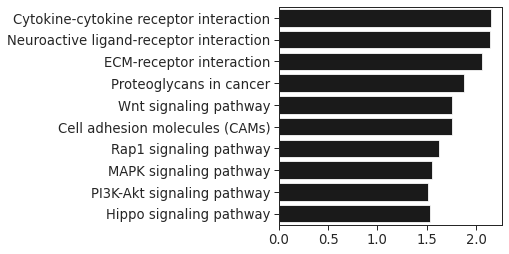

In [74]:
pre_res.res2d['Term'] = pre_res.res2d.index

fig,ax=plt.subplots(figsize=(4,4))
sns.barplot(data=pre_res.res2d.loc[to_plot],x='nes',y='Term',color='k')
ax.set_xlabel("")
ax.set_ylabel("")

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_BarplotGSEA.pdf"
                ,bbox_inches='tight')

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_BarplotGSEA.svg"
                ,bbox_inches='tight')

In [75]:
pre_res.res2d.loc['Cytokine-cytokine receptor interaction']['ledge_genes'].split(";")

['GDF10',
 'CXCL13',
 'IL18RAP',
 'IL24',
 'IFNG',
 'TGFB2',
 'IL19',
 'CXCL14',
 'IL11',
 'TNFRSF8',
 'CCL4',
 'CNTFR',
 'INHBB',
 'CCL5',
 'TNFRSF13B',
 'IL1RN',
 'IL23A',
 'CSF2',
 'CCL20',
 'TNFRSF11B',
 'TNFSF8',
 'BMP15',
 'BMP6',
 'CSF1R',
 'NGF',
 'IL1RL1',
 'LIF',
 'IL18R1',
 'INHBA',
 'NGFR',
 'TNFRSF11A',
 'TNFSF4',
 'CCL24',
 'CCL9',
 'CXCL2',
 'IL16',
 'TNFRSF19',
 'TNFRSF9',
 'INHA',
 'TNFSF10',
 'CD40',
 'BMPR1B',
 'CCL3',
 'TNFSF18',
 'IL1R2',
 'IL2RA',
 'CXCR2',
 'BMP3',
 'TNFRSF1B',
 'TGFBR2',
 'RELT',
 'IL1RL2',
 'IL1F6',
 'BMP5',
 'IL18',
 'IL27RA',
 'CXCL16',
 'CCR5',
 'CSF1',
 'TNFRSF12A',
 'PRL',
 'CCL2',
 'CXCL12',
 'ACVR1',
 'TNF',
 'CSF2RB2',
 'CCR1',
 'CXCL1',
 'CCL17',
 'CCR7',
 'CCL6',
 'IL1RAP',
 'LTB',
 'IL17RA',
 'BMP2',
 'GDF6',
 'EPOR',
 'IL7',
 'AMH',
 'EDA2R',
 'IL1R1',
 'CCL8',
 'TNFRSF25',
 'CXCL15',
 'IL15RA',
 'IL15',
 'TNFSF14',
 'TNFSF13B']

In [76]:
entropy_corrs['p-value'] = entropy_corrs_p
entropy_corrs = entropy_corrs.set_index("gene")    

In [77]:
cytokine_correlations = entropy_corrs.loc[pre_res.res2d.sort_values("fdr").iloc[0]['genes'].split(";")].sort_values("correlation")

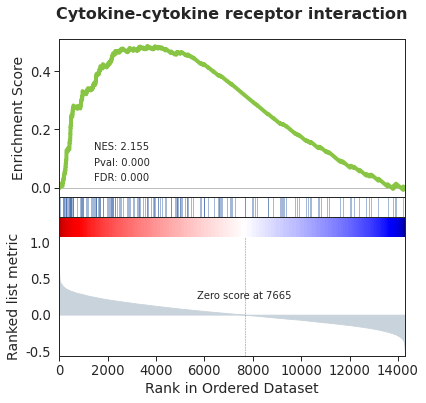

In [78]:
gseaplot(rank_metric=pre_res.ranking, term="Cytokine-cytokine receptor interaction",
         **pre_res.results['Cytokine-cytokine receptor interaction'])

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_CytoGSEA.pdf"
                ,bbox_inches='tight')

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_CytoGSEA.svg"
                ,bbox_inches='tight')

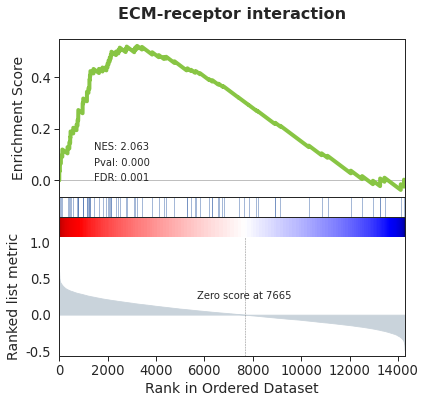

In [79]:
gseaplot(rank_metric=pre_res.ranking, term="ECM-receptor interaction",
         **pre_res.results['ECM-receptor interaction'])
plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_ECMGSEA.pdf"
                ,bbox_inches='tight')

plt.savefig(working_dir+"final_figures/Figure3/ProgressionCohortMetacellInt_ECMGSEA.svg"
                ,bbox_inches='tight')

In [80]:
entropy_corrs.to_csv(working_dir+"final_outputs/Figure3/Plasticity_Correlations.csv")

In [81]:
pre_res.res2d.to_csv(working_dir+"final_outputs/Figure3/GSEA_Plasticity_Correlations.csv")